In [29]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torch.optim.lr_scheduler as lr_scheduler
import time
import json
import matplotlib.pyplot as plt

# Data Exploration

In [3]:
import pandas as pd

df_train = pd.read_csv("/kaggle/input/hc18-grand-challenge/training_set_pixel_size_and_HC.csv")
df_test = pd.read_csv("/kaggle/input/hc18-grand-challenge/test_set_pixel_size.csv")

In [4]:
df_train

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81
...,...,...,...
994,801_HC.png,0.296851,329.26
995,802_HC.png,0.212267,330.90
996,803_HC.png,0.202743,331.70
997,804_HC.png,0.281090,316.48


In [5]:
df_test

,filename,pixel size(mm)
0,000_HC.png,0.235857
1,001_HC.png,0.067973
2,002_HC.png,0.165202
3,003_HC.png,0.096674
4,004_HC.png,0.202203
...,...,...
330,330_HC.png,0.138479
331,331_HC.png,0.075739
332,332_HC.png,0.113107
333,333_HC.png,0.219140


# Visualize image

### Image train

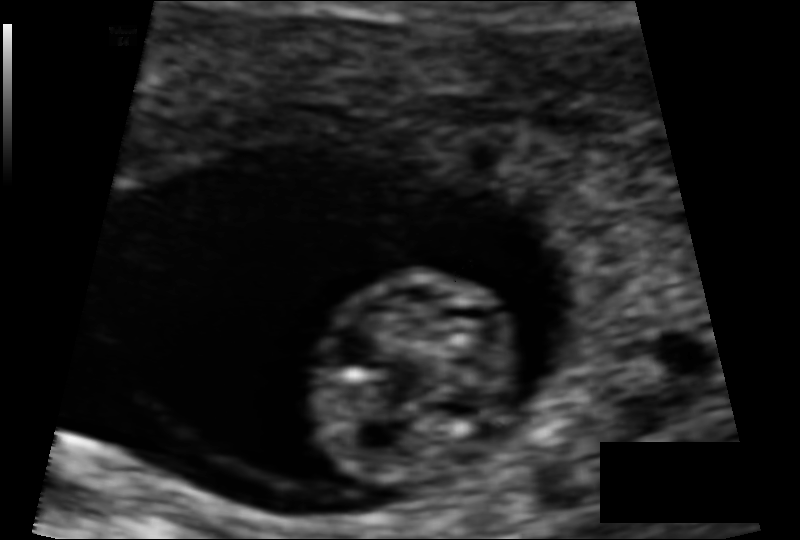

In [6]:
import os
from PIL import Image
im = Image.open("../input/hc18-grand-challenge/training_set/000_HC.png")
im

### Label

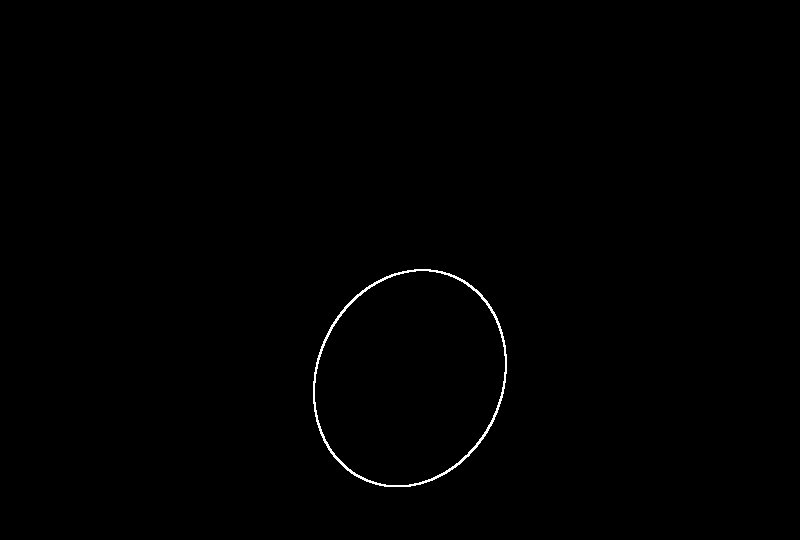

In [7]:
im_an = Image.open("../input/hc18-grand-challenge/training_set/000_HC_Annotation.png")
im_an

We inspect the data in both 2 images

In [8]:
import numpy as np
im_arr = np.array(im)
im_an_arr = np.array(im_an)
print("Image train converted to Numpy: ", im_arr)
print("im_arr's shape: ", im_arr.shape)
print("Unique im_arr: ", np.unique(im_arr))
print("Image annotation converted to Numpy: ", im_an_arr)
print("im_an_arr's shape: ", im_an_arr.shape)
print("Unique im_an_arr: ", np.unique(im_an_arr))

Image train converted to Numpy:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
im_arr's shape:  (540, 800)
Unique im_arr:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 158 159 160 161 162 163
 164 165 166 167 168 169 171 172 173 175 176 177 179 180 182 183 185 186
 187 189 190 191 193 194 196 197 198 200 201 202 203 204 206 207 208 209


We can see clearly that the annotation file only have 2 binary values of 0 or 255

# Data Pre-processing

## Labels fill-in

In [9]:
import cv2
import numpy as np

gray = cv2.imread('/kaggle/input/hc18-grand-challenge/training_set/000_HC_Annotation.png', cv2.IMREAD_GRAYSCALE)

h, w = gray.shape[:2]
mask = np.zeros((h + 2, w + 2), np.uint8)

seed_point = (10, 10)  # Surely outside the hole
fill_color = 255  # White color to fill the hole (grayscale value)

# Perform flood fill on grayscale image
cv2.floodFill(gray, mask, seed_point, fill_color, loDiff=5, upDiff=5, flags=cv2.FLOODFILL_FIXED_RANGE)

# Invert grayscale image
inverted = cv2.bitwise_not(gray)
inverted.shape

(540, 800)

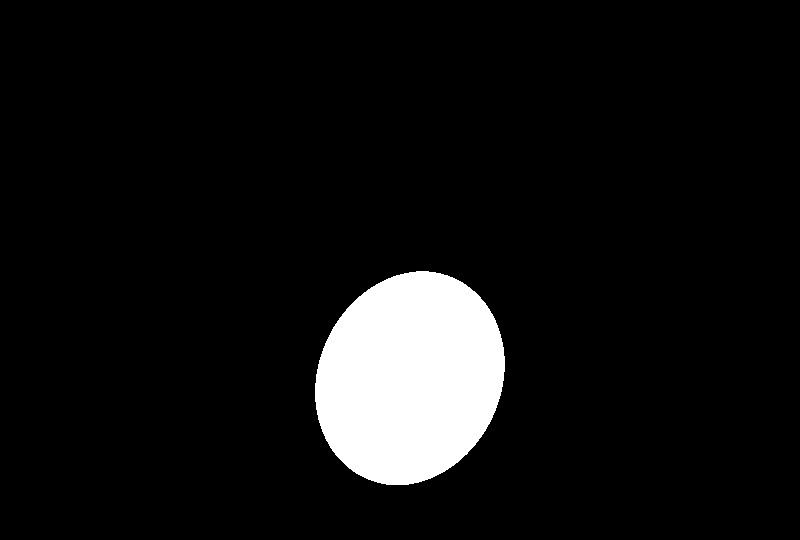

In [10]:
Image.fromarray(inverted)

# Dataset

In [11]:
from torch.utils.data import Dataset

class HC18Dataset(Dataset):
    def __init__(
        self,
        root_dir,
        annotation_file,
        transform = None,
        # isTrain: bool = True,
    ):
        self.root_dir = root_dir
        self.annotation_file = annotation_file
        self.transform = transform

        with open(annotation_file, 'r', encoding='utf8') as ann_file:
            lines = ann_file.readlines()[1:]
            image_files = [l.split(',')[0] for l in lines]
        seg_image_files = [f"{l.split('.')[0]}_Annotation.{l.split('.')[1]}" for l in image_files]
        self.n_samples = len(image_files)

        image_paths = []
        seg_paths = []
        
        for i in tqdm(range(self.n_samples), ncols=100):
            image_path = os.path.join(root_dir, image_files[i])
            image_paths.append(image_path)
            seg_path = os.path.join(root_dir, seg_image_files[i])
            seg_paths.append(seg_path)
            
        self.image_paths = image_paths
        self.seg_paths = seg_paths
            
    def label_fill_in(self, index):
        gray = cv2.imread(self.seg_paths[index], cv2.IMREAD_GRAYSCALE)
        h, w = gray.shape[:2]
        mask = np.zeros((h + 2, w + 2), np.uint8)
        seed_point = (10, 10)  # Surely outside the hole
        fill_color = 255  # White color to fill the hole (grayscale value)
        cv2.floodFill(gray, mask, seed_point, fill_color, loDiff=5, upDiff=5, flags=cv2.FLOODFILL_FIXED_RANGE)
        inverted = cv2.bitwise_not(gray)
    
        return inverted

    def __getitem__(self, index):
        img = Image.open(self.image_paths[index])
        seg = self.label_fill_in(index)
        seg = Image.fromarray(seg)
        if self.transform:
            img = self.transform(img)
            seg = self.transform(seg)
        sample = {"image": img, "segmentation": seg}
        return sample
        
    def __len__(self):
        return len(self.image_paths)
            
            
        

In [12]:
# Define (0,1) scaling 
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((540, 800)),
    # transforms.Resize((135, 200)), # Test for faster experiment
    transforms.ToTensor(),  # Converts PIL image to tensor & scales to [0,1]
])

In [13]:
with open('/kaggle/input/hc18-grand-challenge/training_set_pixel_size_and_HC.csv', 'r', encoding='utf8') as ann_file:
    lines = ann_file.readlines()[1:]
print(lines[:5])

['000_HC.png,0.0691358041432,44.3\n', '001_HC.png,0.0896585200514,56.81\n', '002_HC.png,0.062032562715,68.75\n', '003_HC.png,0.0912911675193,69.0\n', '004_HC.png,0.0612398400539,59.81\n']


In [14]:
full_dataset = HC18Dataset(root_dir='/kaggle/input/hc18-grand-challenge/training_set', annotation_file='/kaggle/input/hc18-grand-challenge/training_set_pixel_size_and_HC.csv', transform=transform)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.1, 0.1])

100%|█████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 421370.65it/s]


In [15]:
# Set batch_size
batch_size = 8

In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [17]:
train_dataset[0]['image'].shape

torch.Size([1, 540, 800])

# UNet Model

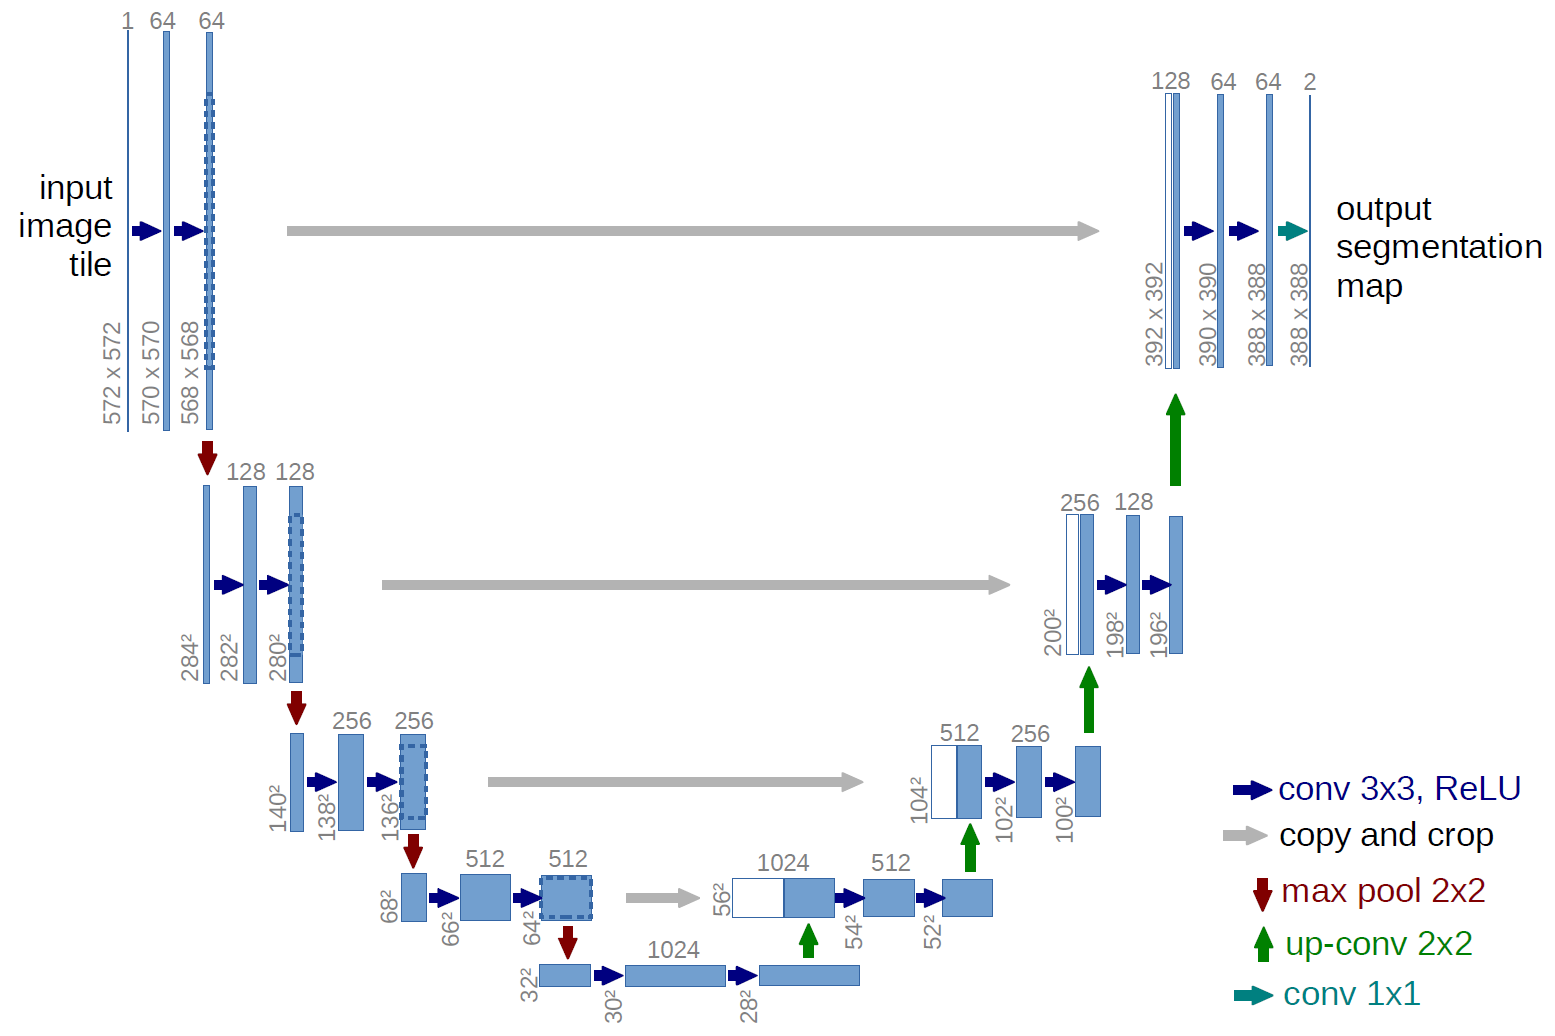

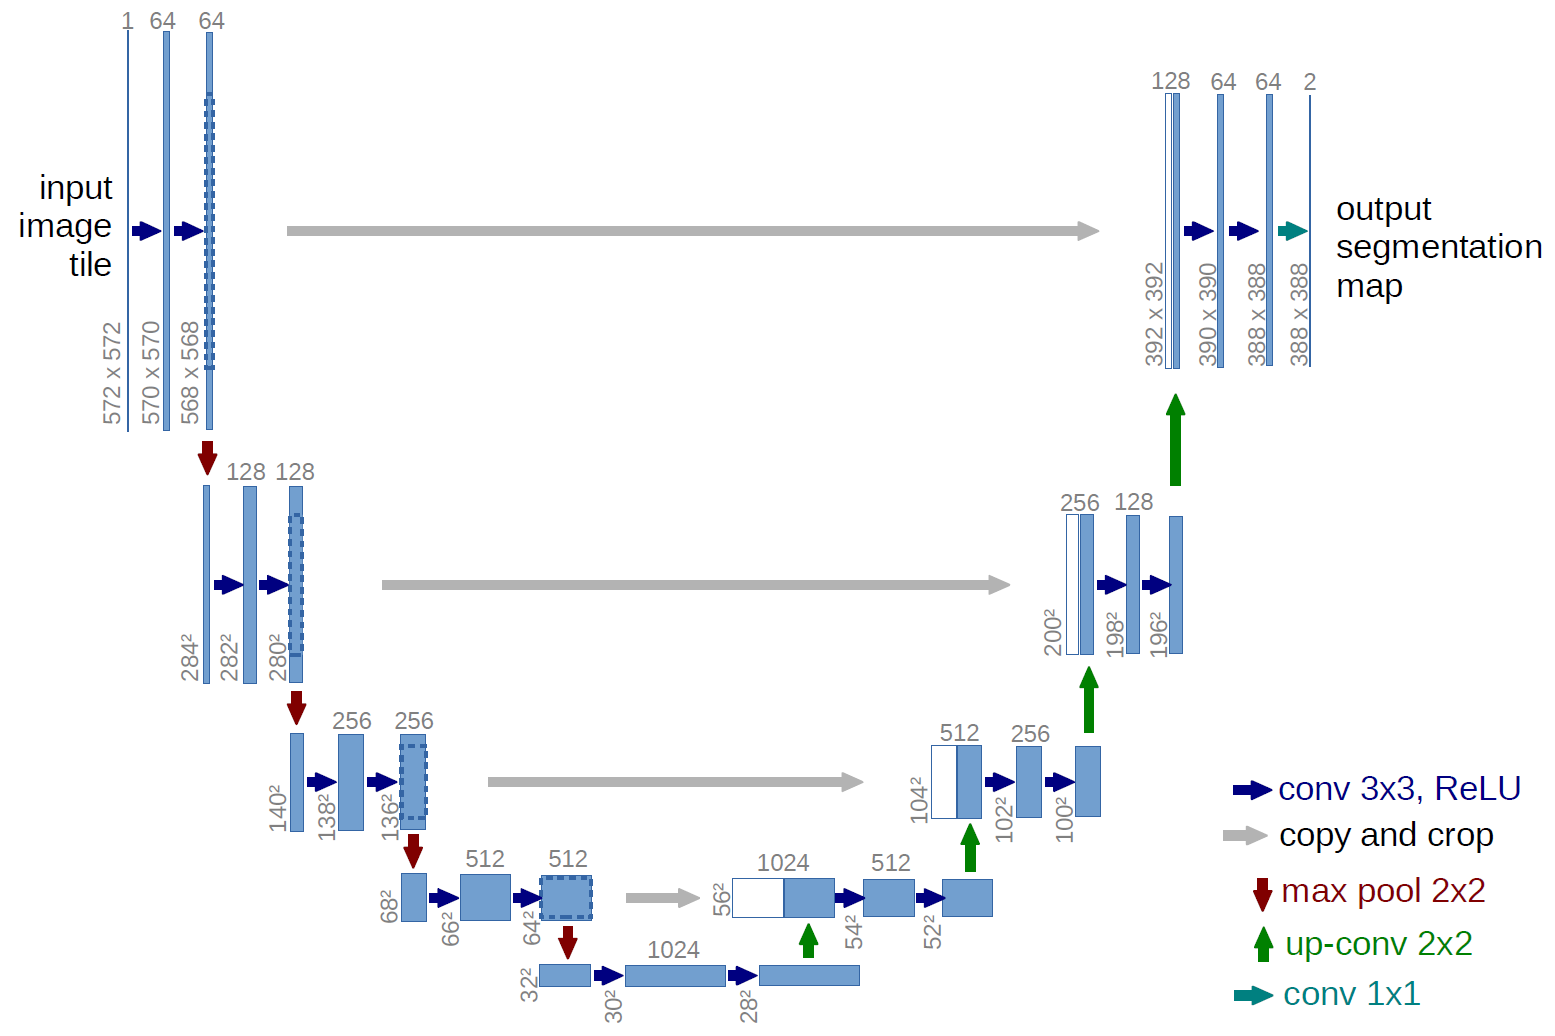

In [18]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)
        
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # MaxPooling (same for each layer)
        self.pool = nn.MaxPool2d(2, stride=2)
        
        # Encoder UNet
        self.enc1 = DoubleConv(1, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        

        # Bottle neck
        self.bottleneck = DoubleConv(512, 1024)


        # Decoder Unet
        self.updec1 = nn.ConvTranspose2d(1024, 512, 2, stride=2, output_padding=(1, 0))
        self.dec1 = DoubleConv(1024, 512)
        self.updec2 = nn.ConvTranspose2d(512, 256, 2, stride=2, output_padding=(1, 0))
        self.dec2 = DoubleConv(512, 256)
        self.updec3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = DoubleConv(256, 128)
        self.updec4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec4 = DoubleConv(128, 64)
        self.final_dec = nn.Conv2d(64, 1, 1)


    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.updec1(b)
        cat4 = torch.cat([d4, e4], 1)
        d3 = self.updec2(self.dec1(cat4))
        cat3 = torch.cat([d3, e3], 1)
        d2 = self.updec3(self.dec2(cat3))
        cat2 = torch.cat([d2, e2], 1)
        d1 = self.updec4(self.dec3(cat2))
        # print("d1: ", d1.shape)
        # print("e1: ", e1.shape)
        cat1 = torch.cat([d1, e1], 1)
        
        z = self.final_dec(self.dec4(cat1))
        return z
        
        

In [19]:
model = UNet()
x_train_tensor = torch.randn(1, 1, 540, 800) # B x C x H x W
output = model(x_train_tensor)
print(output.shape)

torch.Size([1, 1, 540, 800])


# Train model UNet

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = UNet()
model.to(device)

Using device: cuda


UNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
 

In [21]:
optimizer = optim.Adam(model.parameters(), lr=5e-4)

## Implement Dice Loss

In [22]:
class DiceLoss(nn.Module):
    """Dice Loss for binary segmentation.
    
    Args:
        weight: A float tensor for class weighting (optional).
    """

    def __init__(self, weight=None):
        super(DiceLoss, self).__init__()
        self.smooth = 1e-5
        if weight is not None:
            self.weight = torch.tensor(weight, dtype=torch.float32)
        else:
            self.weight = None

    def forward(self, predict, target):
        """
        Args:
            predict: Tensor of shape (N, 1, H, W) with raw logits.
            target: Tensor of shape (N, H, W) with binary values {0,1}.
        Returns:
            Dice loss scalar.
        """
        predict = torch.sigmoid(predict)  # Convert logits to probabilities

        predict = predict.view(predict.shape[0], -1)  # Flatten to (N, H*W)
        target = target.view(target.shape[0], -1)  # Flatten to (N, H*W)

        # Compute Dice coefficient
        intersection = (predict * target).sum(dim=1)  # Sum over spatial dimensions
        union = predict.sum(dim=1) + target.sum(dim=1)  # Sum of both

        dice_coef = (2 * intersection + self.smooth) / (union + self.smooth)  # Per-batch Dice

        # Apply class weight if provided
        dice_loss = 1 - dice_coef.mean()  # Mean loss over batch
        if self.weight is not None:
            self.weight = self.weight.to(predict.device, dtype=predict.dtype)
            dice_loss *= self.weight  # Apply weight scaling

        return dice_loss

## Intersection over union

In [23]:
def iou_coefficient(predict, target, threshold=0.5, smooth=1e-5):
    """
    Computes the Intersection over Union (IoU) for binary segmentation.
    
    Args:
        predict: Tensor of shape (N, 1, H, W) with raw logits or probabilities.
        target: Tensor of shape (N, H, W) with binary values {0,1}.
        threshold: Threshold to binarize predictions (default=0.5).
        smooth: Small value to avoid division by zero.
    
    Returns:
        IoU score (scalar value).
    """
    predict = torch.sigmoid(predict)  # Convert logits to probabilities
    predict = (predict > threshold).float()  # Binarize predictions

    predict = predict.view(predict.shape[0], -1)  # Flatten to (N, H*W)
    target = target.view(target.shape[0], -1)  # Flatten to (N, H*W)

    intersection = (predict * target).sum(dim=1)  # Element-wise multiplication and sum
    union = (predict + target).sum(dim=1) - intersection  # Union = A + B - Intersection

    iou = (intersection + smooth) / (union + smooth)  # Compute IoU per batch

    return iou.mean()  # Average over batch

In [23]:
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
validation_step = 1
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)  # Wrap model for multi-GPU

loss_train_dict = []
loss_val_dict = []
iou_train_dict = []  # Store IoU during training
iou_val_dict = []  # Store IoU during validation
lr_dict = []

dice_loss = DiceLoss()  # Use Dice Loss
num_epochs = 50  # Example: Set your desired number of epochs

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_iou_train = 0  # Track IoU for training
    start_time = time.time()

    for batch_idx, batch in enumerate(train_loader):
        inputs, targets = batch["image"].to(device), batch["segmentation"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = dice_loss(outputs, targets)  # Use Dice Loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Compute IoU for training
        iou = iou_coefficient(outputs, targets)
        total_iou_train += iou.item()
        if batch_idx % 5 == 0:
            print(f"Batch {batch_idx} of Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss:.4f}, Train IoU: {iou:.4f}")

    epoch_time = (time.time() - start_time) * 1000 / len(train_loader)
    train_loss = total_loss / len(train_loader)
    avg_iou_train = total_iou_train / len(train_loader)

    # Append to tracking lists
    loss_train_dict.append(train_loss)
    iou_train_dict.append(avg_iou_train)

    if (epoch + 1) % validation_step == 0:
        model.eval()
        val_loss = 0
        total_iou_val = 0

        with torch.no_grad():
            for batch in val_loader:
                X_val, y_val = batch["image"].to(device), batch["segmentation"].to(device)
                outputs = model(X_val)

                loss = dice_loss(outputs, y_val)
                val_loss += loss.item()
                
                # Compute IoU for validation
                iou = iou_coefficient(outputs, y_val)
                total_iou_val += iou.item()

        val_loss /= len(val_loader)
        avg_iou_val = total_iou_val / len(val_loader)

        print(f"###Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val IoU: {avg_iou_val:.4f}###")
        
        # Append to tracking lists
        loss_val_dict.append(val_loss)
        iou_val_dict.append(avg_iou_val)

        scheduler.step(1-avg_iou_val)

    current_lr = optimizer.param_groups[0]['lr']
    lr_dict.append(current_lr)

    print(f"###Epoch {epoch+1}/{num_epochs} - "
          f"{epoch_time:.0f}ms/step - "
          f"loss: {train_loss:.4f} - "
          f"train IoU: {avg_iou_train:.4f} - "
          f"learning_rate: {current_lr:.4f}###")
    torch.save(model.module.state_dict(), f"unet_epoch_{epoch+1}.pth") 

training_results = {
    "loss_train": loss_train_dict,
    "loss_val": loss_val_dict,
    "iou_train": iou_train_dict,
    "iou_val": iou_val_dict,
    "learning_rate": lr_dict
}
with open('/kaggle/working/training_results', "w") as json_file:
    json.dump(training_results, json_file, indent=4)

print("Training complete...")


Using 2 GPUs!
Batch 0 of Epoch [1/50], Train Loss: 0.6370, Train IoU: 0.2115


In [1]:
torch.save(model.module.state_dict(), "unet.pth") 

NameError: name 'torch' is not defined

In [26]:
model_path = "/kaggle/input/unet_hc18/pytorch/epoch-50/1/unet_epoch_50.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

<ipython-input-26-9753ee9d3b41>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


UNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
 

In [27]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image

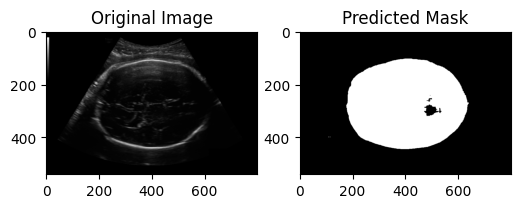

In [30]:
# Inference function
def predict(image_path):
    image = preprocess_image(image_path)

    with torch.no_grad():
        output = model(image)

    output = output.squeeze().cpu().numpy()  # Convert to numpy array
    return (output > 0.5).astype(np.uint8)  # Apply threshold (binarize)

test_image_path = "/kaggle/input/hc18-grand-challenge/test_set/000_HC.png"
pred_mask = predict(test_image_path)

# Display result
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(Image.open(test_image_path), cmap="gray")
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.show()
